In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Input pipeline

In [2]:
BUFFER_SIZE = 1000
BATCH_SIZE = 60
IMG_WIDTH = 32
IMG_HEIGHT = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

(mnist_train, mnist_test) = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

# Font data is unlabeled so add 0's as dummy labels.
f = np.load("font_data.npz")
font_train, font_test = f["train"], f["test"]
font_train = tf.data.Dataset.from_tensor_slices((font_train, np.zeros(len(font_train))))
font_test = tf.data.Dataset.from_tensor_slices((font_test, np.zeros(len(font_test))))

In [3]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[28, 28, 1])

  return cropped_image

In [4]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  image = tf.image.resize(image, [32, 32], method=tf.image.ResizeMethod.BILINEAR)
  return image

In [5]:
def random_jitter(image):
  image = tf.image.resize(image, [30, 30],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = random_crop(image)
  image = tf.image.random_flip_left_right(image)

  return image

In [6]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [7]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [8]:
font_train = font_train.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

mnist_train = mnist_train.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

font_test = font_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

mnist_test = mnist_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
sample_font = next(iter(font_train))
sample_mnist = next(iter(mnist_train))

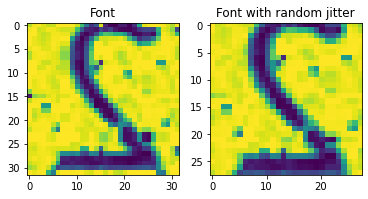

In [10]:
plt.subplot(121)
plt.title('Font')
plt.imshow(sample_font[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Font with random jitter')
plt.imshow(random_jitter(sample_font[0]) * 0.5 + 0.5)

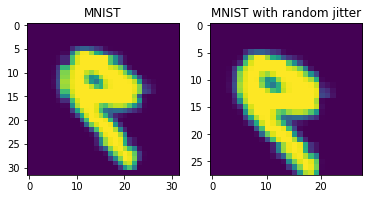

In [11]:
plt.subplot(121)
plt.title('MNIST')
plt.imshow(sample_mnist[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('MNIST with random jitter')
plt.imshow(random_jitter(sample_mnist[0]) * 0.5 + 0.5)

## Modified Pix2Pix models

In [12]:


OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[32,32,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 16, 16, 64)
    downsample(128, 4), # (bs, 8, 8, 128)
    downsample(256, 4), # (bs, 4, 4, 256)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(256, 4), # (bs, 4, 4, 512)
    upsample(128, 4), # (bs, 8, 8, 256)
    upsample(64, 4), # (bs, 16, 16, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 32, 32, 1)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  x = tf.keras.layers.Input(shape=[32, 32, 1], name='input_image')

  down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
  down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
  down3 = downsample(256, 4)(down2) # (bs, 4, 4, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs=x, outputs=last)

In [13]:
generator_g = Generator()
generator_f = Generator()

discriminator_x = Discriminator()
discriminator_y = Discriminator()

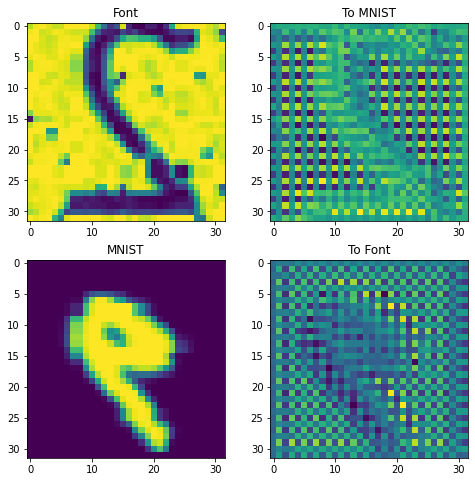

In [14]:
to_mnist = generator_g(sample_font)
to_font = generator_f(sample_mnist)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_font, to_mnist, sample_mnist, to_font]
title = ['Font', 'To MNIST', 'MNIST', 'To Font']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

## Loss functions

In [15]:
LAMBDA = 10

In [16]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [18]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [19]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [20]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [21]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [22]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Training

In [28]:
EPOCHS = 40

In [24]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [25]:
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

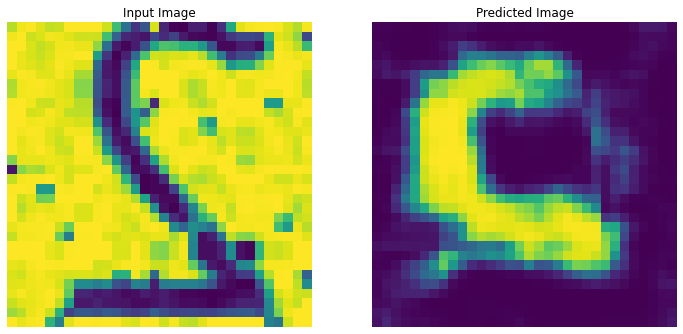

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-8
Time taken for epoch 10 is 160.9389066696167 sec



In [26]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((font_train, mnist_train)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)

  generate_images(generator_g, sample_font)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generate using test dataset

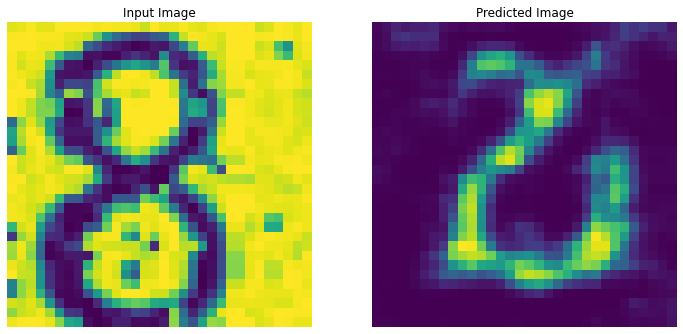

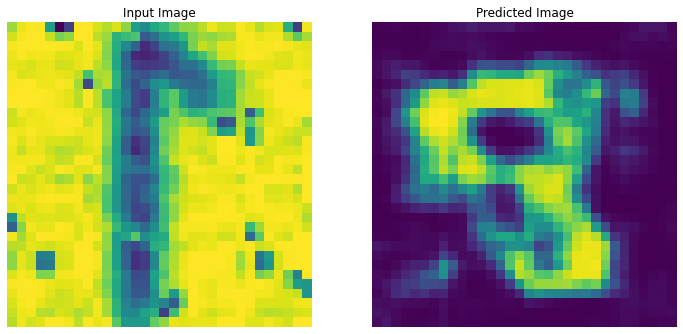

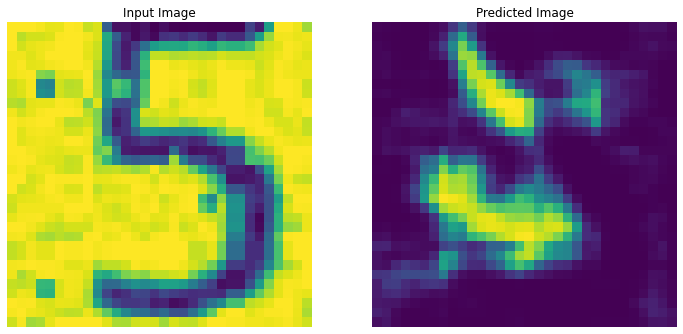

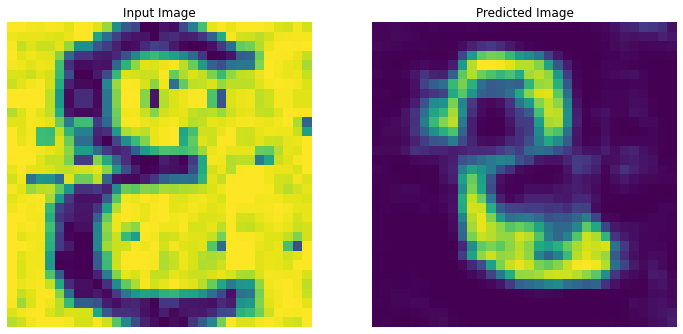

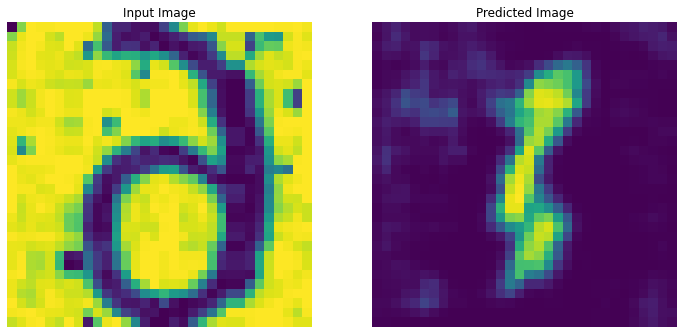

In [27]:
for inp in font_train.take(5):
  generate_images(generator_g, inp)